# Preprocessing

In this section, we will cover the preprocessing steps required to prepare our data for analysis.

In [1]:
import os, sys
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir,'..')))

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.data_load import load_data

# Load data
data = load_data('../data/train.csv')
store = load_data('../data/store.csv')
df = pd.merge(data, store, on="Store")


c:\Users\USER\Documents\10X Exercises\Week-4_rossmann_pharmaceuticals\scripts\data_load.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [3]:
# Fill NaN values
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_13496\1516938536.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_13496\1516938536.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract datetime features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Days to/from holidays (example for Christmas)
df['DaysToChristmas'] = (pd.to_datetime(df['Year'].astype(str) + '-12-25') - df['Date']).dt.days.clip(lower=0)
df['DaysFromChristmas'] = (df['Date'] - pd.to_datetime(df['Year'].astype(str) + '-12-25')).dt.days.clip(lower=0)

# Month parts
df['MonthPart'] = pd.cut(df['Day'], bins=[0, 10, 20, 31], labels=['Start', 'Mid', 'End'])


In [6]:
# Identify numerical and categorical columns
numerical_columns = ['Sales', 'Customers', 'CompetitionDistance', 'DaysToChristmas', 'DaysFromChristmas']
categorical_columns = ['StoreType', 'Assortment', 'Promo', 'StateHoliday', 'MonthPart']

# Build Column Transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
])


 Building Models with sklearn Pipelines

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert categorical columns to strings
for col in categorical_columns:
    df[col] = df[col].astype(str)

# Define pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data
X = df.drop(columns=['Date'])
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Sales', 'Customers',
                                                   'CompetitionDistance',
                                                   'DaysToChristmas',
                                                   'DaysFromChristmas']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['StoreType', 'Assortment',
                                                   'Promo', 'StateHoliday',
                                                   'MonthPart'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [15]:
# Predictions
y_pred = pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 0.040582524749072854
Root Mean Squared Error: 8.394568335656235


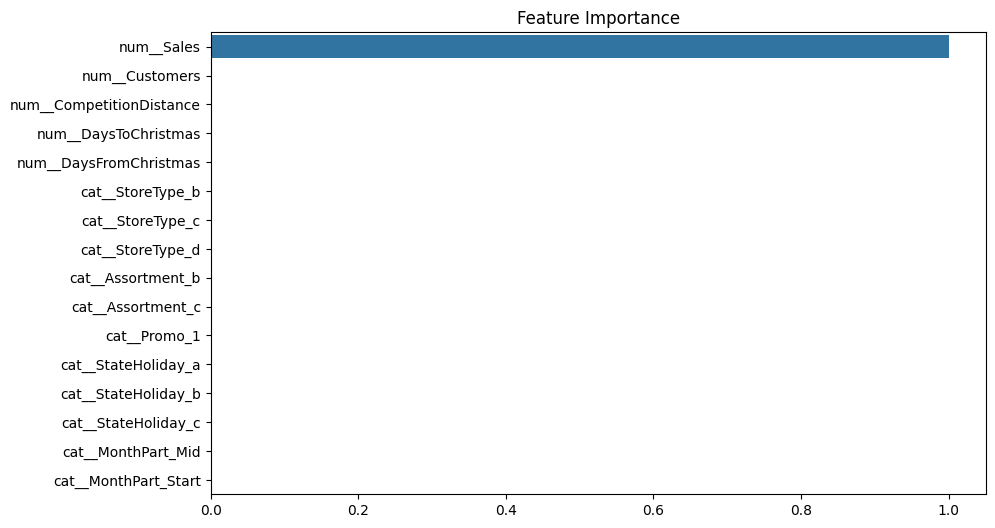

In [17]:
# Extract feature importances
model = pipeline.named_steps['model']
feature_importances = model.feature_importances_

# Get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

In [18]:
# Bootstrap confidence intervals
n_bootstraps = 1000
bootstrapped_preds = []

for _ in range(n_bootstraps):
    sample_idx = np.random.choice(len(X_test), len(X_test), replace=True)
    bootstrapped_preds.append(pipeline.predict(X_test.iloc[sample_idx]))

ci_lower = np.percentile(bootstrapped_preds, 2.5, axis=0)
ci_upper = np.percentile(bootstrapped_preds, 97.5, axis=0)


In [19]:
import joblib

# Save the model
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
joblib.dump(pipeline, f'model-{timestamp}.pkl')

['model-2025-01-14-21-33-22.pkl']

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
sales_scaled = scaler.fit_transform(df[['Sales']])

# Sliding window
X = []
y = []
window_size = 30

for i in range(window_size, len(sales_scaled)):
    X.append(sales_scaled[i - window_size:i, 0])
    y.append(sales_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

In [29]:
# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
%pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Note: you may need to restart the kernel to use updated packages.


SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)